# Machine Learning Modelling

## Hotel Booking - Price Prediction

### Import Libraries

In [1]:
## General
import math
import pickle
import numpy as np
import pandas as pd

## EDA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
colour_palette = sns.color_palette("hls", 8)

## Machine Learning
# Pre-Processing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler      # Remove Mean and scale to Unit Variance
from sklearn.preprocessing import PowerTransformer    # Log Transformation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import lightgbm as ltb
import xgboost as xgb
import catboost as cb

### Import Dataset

In [2]:
## Importing Data
data_hotel_bookings = pd.read_csv('../../Dataset/hotel_booking/hotel_bookings.csv')

## Understanding Data I
data_hotel_bookings.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [3]:
## Understanding Data II
print(data_hotel_bookings.dtypes)

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [4]:
## Understanding Data III
data_hotel_bookings

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


### Pre-Processing

In [5]:
## Check Missing Data
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

children         4
country        488
agent        16340
company     112593
dtype: int64

In [6]:
## Fill Missing Data

# For Children
data_hotel_bookings.children.fillna(0, inplace = True)

# For Country
data_hotel_bookings.country.fillna("Unknown", inplace = True)

# For Agent
data_hotel_bookings.loc[data_hotel_bookings.agent.isnull() == False, 'agent'] = 'Agent'
data_hotel_bookings.agent.fillna("No Agent", inplace = True)

# For Company 
data_hotel_bookings.loc[data_hotel_bookings.company.isnull() == False, 'company'] = 'Corporate'
data_hotel_bookings.company.fillna("No Company", inplace = True)

# Re-Confirm 
data_hotel_bookings.isnull().sum()[data_hotel_bookings.isnull().sum() > 0]

Series([], dtype: int64)

In [7]:
## Changing Data Types
data_hotel_bookings['children'] = data_hotel_bookings['children'].astype('int') 

In [8]:
## Adjust to suit Streaming Data - Hotel Reservation
data_hotel_bookings.loc[(data_hotel_bookings['meal'] == 'Undefined'), 'meal']= 'SC'
data_hotel_bookings.loc[(data_hotel_bookings['required_car_parking_spaces'] > 1), 'required_car_parking_spaces']= 1

In [9]:
## Separating Data
data_hotel_bookings_resort = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "Resort Hotel"]
data_hotel_bookings_city = data_hotel_bookings.loc[data_hotel_bookings["hotel"] == "City Hotel"]

In [10]:
## Selecting Columns in both Hotel Booking & Hotel Reservation
data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel', 
                               'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'is_canceled', 
                               'days_in_waiting_list', 'customer_type', 'reservation_status', 'reservation_status_date',
                               'arrival_date_day_of_month'], 
                              axis = 1, inplace = True)

print(data_hotel_bookings_city.dtypes)

lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                            int32
meal                               object
market_segment                     object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
adr                               float64
required_car_parking_spaces         int64
total_of_special_requests           int64
dtype: object


C:\Users\KMwong\AppData\Local\Temp\ipykernel_16788\30062519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(['hotel', 'arrival_date_week_number', 'babies', 'country', 'distribution_channel',


### Feature Engineering

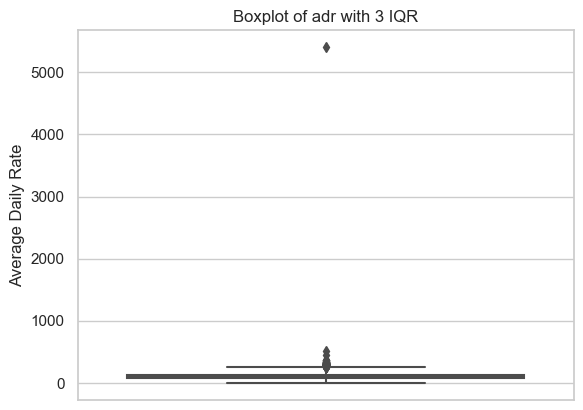

In [11]:
# Outlier Analysis for adr
adr_box = sns.boxplot(y = data_hotel_bookings_city["adr"], whis=3.0)
adr_box.set(ylabel = "Average Daily Rate",
                 title = "Boxplot of adr with 3 IQR")
plt.show()

C:\Users\KMwong\AppData\Local\Temp\ipykernel_16788\3980463777.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index
C:\Users\KMwong\AppData\Local\Temp\ipykernel_16788\3980463777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index


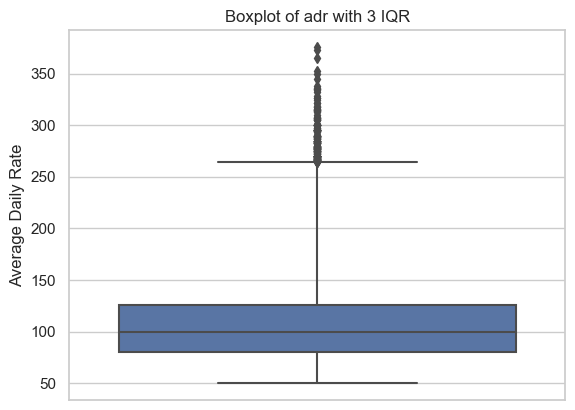

In [12]:
# Further Cleaning Data for adr
data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index 
                                           if 400 < data_hotel_bookings_city.loc[row, 'adr']], 
                                      inplace = True)
data_hotel_bookings_city.drop(index = [row for row in data_hotel_bookings_city.index 
                                            if 50 >= data_hotel_bookings_city.loc[row, 'adr']], 
                                      inplace = True)

# Visualising Box Again
adr_cleaned_box = sns.boxplot(y = data_hotel_bookings_city["adr"], whis=3.0)
adr_cleaned_box.set(ylabel = "Average Daily Rate",
                 title = "Boxplot of adr with 3 IQR")
plt.show()

In [13]:
# Rounding adr to nearest integer and convert to int
data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.round()
data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.astype('int')
# print(data_hotel_bookings_city.adr)

C:\Users\KMwong\AppData\Local\Temp\ipykernel_16788\3460971230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.round()
C:\Users\KMwong\AppData\Local\Temp\ipykernel_16788\3460971230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_hotel_bookings_city.adr = data_hotel_bookings_city.adr.astype('int')


In [14]:
## Encoding

# OneHotEncoder (Run Once only)

# perform one-hot encoding for the market_segment column
market_segment_one_hot = pd.get_dummies(data_hotel_bookings_city['market_segment'], prefix='market_segment')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, market_segment_one_hot], axis=1)
# drop the original customer_type column
data_hotel_bookings_city.drop('market_segment', axis=1, inplace=True)

# perform one-hot encoding for the arrival_date_month column
arrival_date_month_one_hot = pd.get_dummies(data_hotel_bookings_city['arrival_date_month'], prefix='arrival_date_month')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, arrival_date_month_one_hot], axis=1)
# drop the original arrival_date_month column
data_hotel_bookings_city.drop('arrival_date_month', axis=1, inplace=True)

# perform one-hot encoding for the meal column
meal_one_hot = pd.get_dummies(data_hotel_bookings_city['meal'], prefix='meal')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, meal_one_hot], axis=1)
# drop the original meal column
data_hotel_bookings_city.drop('meal', axis=1, inplace=True)

# perform one-hot encoding for the reserved_room_type column
reserved_room_type_one_hot = pd.get_dummies(data_hotel_bookings_city['reserved_room_type'], prefix='reserved_room_type')
# concatenate the one-hot encoded columns to the original dataset
data_hotel_bookings_city = pd.concat([data_hotel_bookings_city, reserved_room_type_one_hot], axis=1)
# drop the original reserved_room_type column
data_hotel_bookings_city.drop('reserved_room_type', axis=1, inplace=True)


# LabelEncoder

# create a LabelEncoder object
le = LabelEncoder()

# # apply LabelEncoder to the reservation_status column ('Canceled': -1, 'No-Show': 0, 'Check-Out': 1)
# mapping_rs = {'Canceled': -1, 'No-Show': 0, 'Check-Out': 1}
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(mapping_rs)
# data_hotel_bookings['reservation_status'] = le.fit_transform(data_hotel_bookings['reservation_status'])
# data_hotel_bookings['reservation_status'] = data_hotel_bookings['reservation_status'].map(dict(zip(range(3), mapping_rs.values())))

# # apply LabelEncoder to the deposit_type column ('Non-Refund': -1, 'No Deposit': 0, 'Refundable': 1)
# mapping_dt = {'Non Refund': -1, 'No Deposit': 0, 'Refundable': 1}
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(mapping_dt)
# data_hotel_bookings['deposit_type'] = le.fit_transform(data_hotel_bookings['deposit_type'])
# data_hotel_bookings['deposit_type'] = data_hotel_bookings['deposit_type'].map(dict(zip(range(3), mapping_dt.values())))

# print the result
data_hotel_bookings_city

,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
40061,88,2015,0,4,2,0,0,0,0,76,...,0,0,0,1,0,0,0,0,0,0
40062,65,2015,0,4,1,0,0,0,0,68,...,0,0,0,1,0,0,0,0,0,0
40063,92,2015,2,4,2,0,0,0,0,76,...,0,0,0,1,0,0,0,0,0,0
40064,100,2015,0,2,2,0,0,0,0,76,...,0,0,0,1,0,0,0,0,0,0
40065,79,2015,0,3,2,0,0,0,0,76,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,23,2017,2,5,2,0,0,0,0,96,...,0,0,0,1,0,0,0,0,0,0
119386,102,2017,2,5,3,0,0,0,0,225,...,0,0,0,0,0,0,0,1,0,0
119387,34,2017,2,5,2,0,0,0,0,158,...,0,0,0,0,0,0,1,0,0,0
119388,109,2017,2,5,2,0,0,0,0,104,...,0,0,0,1,0,0,0,0,0,0


In [31]:
## Only Run This For Classification Models (Not Regression Models)
# Create categories for the adr column (1: 50-75 dollars, 2: 76-100 dollars, ..., 376-400 dollars)
bins = [49, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
data_hotel_bookings_city['adr_category'] = pd.cut(data_hotel_bookings_city['adr'], bins=bins, labels=labels)

# print the result
data_hotel_bookings_city[['adr', 'adr_category']].max()

adr             376
adr_category     14
dtype: int64

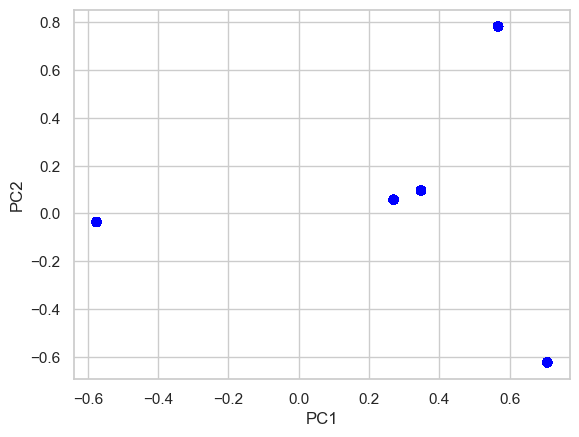

Explained variance ratios: [0.39903576 0.30947183 0.2761266  0.01536582]


In [16]:
## Principal Component Analysis (PCA)

# Select variables for PCA
X = data_hotel_bookings_city[['market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA']]

# Add adr as target variable
y = data_hotel_bookings_city['adr']

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Create scatter plot of first two principal components
colors = ['red' if x == 1 else 'blue' for x in y]
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


X = StandardScaler().fit_transform(X)

pca = PCA()
principalComponents = pca.fit_transform(X)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)

In [17]:
## Correlation Matrix
data_hotel_bookings_city.corr()

,lead_time,arrival_date_year,stays_in_weekend_nights,stays_in_week_nights,adults,children,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,adr,...,meal_FB,meal_HB,meal_SC,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G
lead_time,1.000000,0.023989,-0.031410,0.050649,0.106537,-0.054912,-0.086404,0.128586,-0.058183,-0.203353,...,-0.003432,0.137445,-0.140978,0.144053,0.008221,-0.002205,-0.117323,-0.057698,-0.048082,-0.036768
arrival_date_year,0.023989,1.000000,0.033840,0.066784,0.062846,0.055541,-0.032518,-0.202677,0.020370,0.276675,...,-0.036275,-0.105239,0.152567,-0.127123,-0.034115,-0.006232,0.111213,0.073228,0.024201,0.033698
stays_in_weekend_nights,-0.031410,0.033840,1.000000,0.192614,0.085515,0.038433,-0.063136,-0.037246,-0.020257,0.028024,...,0.003616,-0.010943,-0.000644,-0.088374,0.025368,-0.004697,0.074839,0.018498,0.018890,0.015089
stays_in_week_nights,0.050649,0.066784,0.192614,1.000000,0.092575,0.037938,-0.067061,-0.049293,-0.034886,0.042752,...,-0.003859,-0.032881,-0.031963,-0.123220,0.023607,-0.000891,0.105368,0.035880,0.022468,0.022543
adults,0.106537,0.062846,0.085515,0.092575,1.000000,-0.002238,-0.152411,-0.037081,-0.104728,0.261656,...,-0.035417,0.034464,0.005658,-0.270969,-0.061410,-0.003229,0.269384,0.068376,0.046262,0.070519
children,-0.054912,0.055541,0.038433,0.037938,-0.002238,1.000000,-0.027200,-0.043726,-0.016181,0.378170,...,-0.005386,-0.003766,-0.078701,-0.277851,0.137533,0.002892,-0.059923,0.064590,0.634669,0.210821
is_repeated_guest,-0.086404,-0.032518,-0.063136,-0.067061,-0.152411,-0.027200,1.000000,0.276868,0.448990,-0.102226,...,-0.003157,-0.040486,-0.040080,0.033225,-0.016080,0.005943,-0.027096,0.001632,-0.012747,-0.005800
previous_cancellations,0.128586,-0.202677,-0.037246,-0.049293,-0.037081,-0.043726,0.276868,1.000000,0.388923,-0.146809,...,-0.004163,0.010862,-0.064547,0.076208,-0.007670,0.003052,-0.063861,-0.018663,-0.025763,-0.014162
previous_bookings_not_canceled,-0.058183,0.020370,-0.020257,-0.034886,-0.104728,-0.016181,0.448990,0.388923,1.000000,-0.062064,...,-0.001526,-0.019946,-0.022914,0.017806,-0.007467,-0.000832,-0.019025,0.015989,-0.009655,-0.004976
adr,-0.203353,0.276675,0.028024,0.042752,0.261656,0.378170,-0.102226,-0.146809,-0.062064,1.000000,...,-0.009912,0.123416,-0.071805,-0.490450,-0.036610,0.000415,0.292653,0.209042,0.355494,0.246114


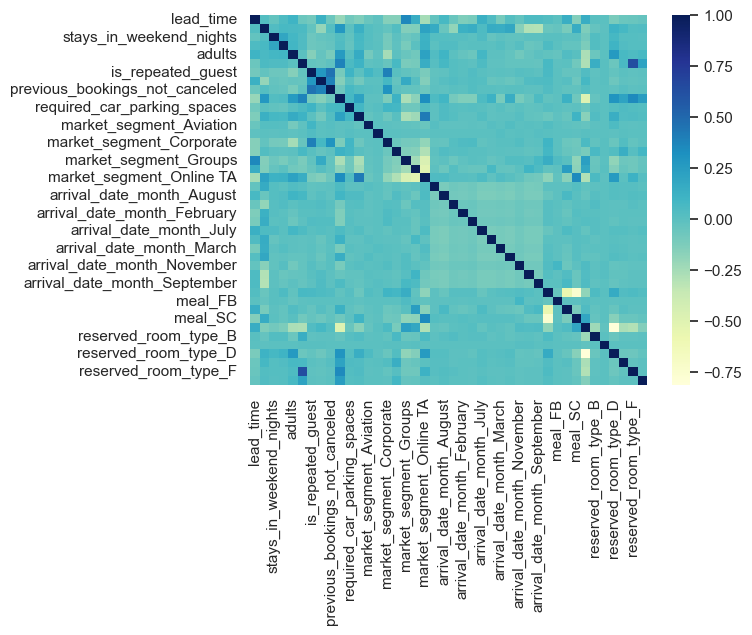

In [18]:
## Correlation Matrix Heatmap
sns.heatmap(data_hotel_bookings_city.corr(), cmap='YlGnBu') #, annot = True, annot_kws={"size":5})
plt.show()

In [19]:
## Feature Importance
corr_adr = data_hotel_bookings_city.corr()["adr"]
corr_adr.abs().sort_values(ascending = False)

adr                               1.000000
reserved_room_type_A              0.490450
children                          0.378170
reserved_room_type_F              0.355494
market_segment_Online TA          0.329458
reserved_room_type_D              0.292653
arrival_date_year                 0.276675
market_segment_Groups             0.268623
adults                            0.261656
reserved_room_type_G              0.246114
total_of_special_requests         0.216427
reserved_room_type_E              0.209042
lead_time                         0.203353
market_segment_Offline TA/TO      0.174534
arrival_date_month_May            0.148707
previous_cancellations            0.146809
arrival_date_month_February       0.138929
arrival_date_month_January        0.134700
meal_HB                           0.123416
market_segment_Direct             0.122120
market_segment_Corporate          0.120952
arrival_date_month_June           0.117705
arrival_date_month_March          0.109926
arrival_dat

In [20]:
## Selecting Features for Model Building
data_hotel_bookings_city_feature = data_hotel_bookings_city

data_hotel_bookings_city_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77396 entries, 40061 to 119389
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   lead_time                       77396 non-null  int64
 1   arrival_date_year               77396 non-null  int64
 2   stays_in_weekend_nights         77396 non-null  int64
 3   stays_in_week_nights            77396 non-null  int64
 4   adults                          77396 non-null  int64
 5   children                        77396 non-null  int32
 6   is_repeated_guest               77396 non-null  int64
 7   previous_cancellations          77396 non-null  int64
 8   previous_bookings_not_canceled  77396 non-null  int64
 9   adr                             77396 non-null  int32
 10  required_car_parking_spaces     77396 non-null  int64
 11  total_of_special_requests       77396 non-null  int64
 12  market_segment_Aviation         77396 non-null  uint8
 

### Model Selection

In [21]:
## Splitting Data (80:20) Regression
x = data_hotel_bookings_city_feature.drop(columns = 'adr')
y = data_hotel_bookings_city_feature.adr 

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((61916, 41), (15480, 41))

In [33]:
## Splitting Data (80:20) Classification
x = data_hotel_bookings_city_feature.drop(columns = ['adr', 'adr_category'])
y = data_hotel_bookings_city_feature.adr_category

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
x_train.shape, x_test.shape

((61916, 41), (15480, 41))

#### Regression Models

In [22]:
## Model : Linear Regression
# Finding linear relationship among more than two quantitative variables

lnr = LinearRegression()
lnr_model = lnr.fit(x_train, y_train)
lnr_y_pred = lnr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, lnr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, lnr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, lnr_y_pred)}")

# # Plot Output
# plt.scatter(x_test, y_test, color="black")
# plt.plot(x_test, lnr_y_pred, color="blue", linewidth=3)
# plt.xticks(())
# plt.yticks(())
# plt.show()

Mean Squared Error: 460.55926807410196
RMSE: 21.46064463323742
R2 Score: 0.6531216217320995


In [23]:
## Model : Random Forest Regressor
# Meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to 
# improve the predictive accuracy and control over-fitting

rfr = RandomForestRegressor()
rfr_model = rfr.fit(x_train, y_train)
rfr_y_pred = rfr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, rfr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, rfr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, rfr_y_pred)}")

Mean Squared Error: 195.35475414358987
RMSE: 13.97693650781851
R2 Score: 0.852865103360921


In [24]:
## Model : Gradient Boosting Regressor
# Builds an additive model in a forward stage-wise fashion for the optimization of arbitrary differentiable loss functions. 
# In each stage a regression tree is fit on the negative gradient of the given loss function.

gbr = GradientBoostingRegressor()
gbr_model = gbr.fit(x_train, y_train)
gbr_y_pred = gbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, gbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, gbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, gbr_y_pred)}")

Mean Squared Error: 398.7257235330045
RMSE: 19.96811767626094
R2 Score: 0.6996926520853979


In [25]:
## Model : Elastic Net
# Linear regression with combined L1 and L2 priors as regularizer

en = ElasticNet()
en_model = en.fit(x_train, y_train)
en_y_pred = en_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, en_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, en_y_pred))}")
print(f"R2 Score: {r2_score(y_test, en_y_pred)}")

Mean Squared Error: 914.0605887386084
RMSE: 30.23343494772978
R2 Score: 0.3115590616901103


In [26]:
## Model : Bayesian Ridge
# Allows a natural mechanism to survive insufficient data or poorly distributed data by formulating linear regression using 
# probability distributors rather than point estimates. 
# The output or response 'y' is assumed to drawn from a probability distribution rather than estimated as a single value.

br = BayesianRidge()
br_model = br.fit(x_train, y_train)
br_y_pred = br_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, br_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, br_y_pred))}")
print(f"R2 Score: {r2_score(y_test, br_y_pred)}")

Mean Squared Error: 460.5270911597477
RMSE: 21.45989494754687
R2 Score: 0.6531458563456283


In [27]:
## Model : LGBM Regressor
# LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
# It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with max delta 
# loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

lgbmr = ltb.LGBMRegressor()
lgbmr_model = lgbmr.fit(x_train, y_train)
lgbmr_y_pred = lgbmr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, lgbmr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, lgbmr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, lgbmr_y_pred)}")

Mean Squared Error: 259.11546601670955
RMSE: 16.09706389428549
R2 Score: 0.8048425927636615


In [28]:
## Model : XGBoost Regressor
# Efficient implementation of gradient boosting that can be used for regression predictive modeling

xgbr = xgb.XGBRegressor()
xgbr_model = xgbr.fit(x_train, y_train)
xgbr_y_pred = xgbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, xgbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, xgbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, xgbr_y_pred)}")

Mean Squared Error: 219.87861617313627
RMSE: 14.828304561652901
R2 Score: 0.8343945218758339


In [29]:
## Model : CatBoost Regressor
# builds upon the theory of decision trees and gradient boosting. 
# The main idea of boosting is to sequentially combine many weak models (a model performing slightly better than random chance) 
# and thus through greedy search create a strong competitive predictive model

cbr = cb.CatBoostRegressor()
cbr_model = cbr.fit(x_train, y_train)
cbr_y_pred = cbr_model.predict(x_test)

# Print Coefficients
print(f"Mean Squared Error: {mean_squared_error(y_test, cbr_y_pred)}")
print(f"RMSE: {math.sqrt(mean_squared_error(y_test, cbr_y_pred))}")
print(f"R2 Score: {r2_score(y_test, cbr_y_pred)}")

Learning rate set to 0.078575
0:	learn: 35.6639151	total: 185ms	remaining: 3m 5s
1:	learn: 34.5877423	total: 205ms	remaining: 1m 42s
2:	learn: 33.6378019	total: 227ms	remaining: 1m 15s
3:	learn: 32.7695095	total: 247ms	remaining: 1m 1s
4:	learn: 31.9593850	total: 269ms	remaining: 53.5s
5:	learn: 31.2223322	total: 289ms	remaining: 47.8s
6:	learn: 30.5435223	total: 308ms	remaining: 43.7s
7:	learn: 29.8872703	total: 329ms	remaining: 40.8s
8:	learn: 29.3571886	total: 347ms	remaining: 38.2s
9:	learn: 28.8403854	total: 365ms	remaining: 36.1s
10:	learn: 28.3862691	total: 383ms	remaining: 34.4s
11:	learn: 27.9032732	total: 400ms	remaining: 32.9s
12:	learn: 27.5174754	total: 416ms	remaining: 31.6s
13:	learn: 27.1265290	total: 431ms	remaining: 30.3s
14:	learn: 26.7704424	total: 446ms	remaining: 29.3s
15:	learn: 26.3785925	total: 463ms	remaining: 28.5s
16:	learn: 26.0393078	total: 479ms	remaining: 27.7s
17:	learn: 25.7559026	total: 496ms	remaining: 27s
18:	learn: 25.4933565	total: 513ms	remaining

167:	learn: 17.9006825	total: 2.75s	remaining: 13.6s
168:	learn: 17.8889470	total: 2.77s	remaining: 13.6s
169:	learn: 17.8620659	total: 2.78s	remaining: 13.6s
170:	learn: 17.8514101	total: 2.8s	remaining: 13.6s
171:	learn: 17.8349945	total: 2.81s	remaining: 13.5s
172:	learn: 17.8198056	total: 2.83s	remaining: 13.5s
173:	learn: 17.8079064	total: 2.84s	remaining: 13.5s
174:	learn: 17.7997072	total: 2.86s	remaining: 13.5s
175:	learn: 17.7930042	total: 2.87s	remaining: 13.4s
176:	learn: 17.7738848	total: 2.88s	remaining: 13.4s
177:	learn: 17.7602513	total: 2.89s	remaining: 13.4s
178:	learn: 17.7501348	total: 2.91s	remaining: 13.3s
179:	learn: 17.7427992	total: 2.92s	remaining: 13.3s
180:	learn: 17.7281620	total: 2.93s	remaining: 13.3s
181:	learn: 17.7089995	total: 2.95s	remaining: 13.3s
182:	learn: 17.7019954	total: 2.96s	remaining: 13.2s
183:	learn: 17.6957814	total: 2.98s	remaining: 13.2s
184:	learn: 17.6863319	total: 2.99s	remaining: 13.2s
185:	learn: 17.6620850	total: 3.01s	remaining: 

328:	learn: 16.4906327	total: 5.26s	remaining: 10.7s
329:	learn: 16.4810503	total: 5.28s	remaining: 10.7s
330:	learn: 16.4753752	total: 5.29s	remaining: 10.7s
331:	learn: 16.4699448	total: 5.31s	remaining: 10.7s
332:	learn: 16.4621175	total: 5.33s	remaining: 10.7s
333:	learn: 16.4583397	total: 5.34s	remaining: 10.6s
334:	learn: 16.4525489	total: 5.36s	remaining: 10.6s
335:	learn: 16.4466549	total: 5.37s	remaining: 10.6s
336:	learn: 16.4303271	total: 5.39s	remaining: 10.6s
337:	learn: 16.4270100	total: 5.4s	remaining: 10.6s
338:	learn: 16.4236806	total: 5.42s	remaining: 10.6s
339:	learn: 16.4176847	total: 5.44s	remaining: 10.6s
340:	learn: 16.4139621	total: 5.45s	remaining: 10.5s
341:	learn: 16.4034774	total: 5.47s	remaining: 10.5s
342:	learn: 16.3937137	total: 5.49s	remaining: 10.5s
343:	learn: 16.3867543	total: 5.5s	remaining: 10.5s
344:	learn: 16.3837568	total: 5.52s	remaining: 10.5s
345:	learn: 16.3770841	total: 5.53s	remaining: 10.5s
346:	learn: 16.3709311	total: 5.55s	remaining: 1

489:	learn: 15.7353778	total: 7.8s	remaining: 8.11s
490:	learn: 15.7291410	total: 7.81s	remaining: 8.1s
491:	learn: 15.7274895	total: 7.83s	remaining: 8.08s
492:	learn: 15.7263543	total: 7.84s	remaining: 8.06s
493:	learn: 15.7214418	total: 7.86s	remaining: 8.05s
494:	learn: 15.7193164	total: 7.87s	remaining: 8.03s
495:	learn: 15.7176776	total: 7.89s	remaining: 8.02s
496:	learn: 15.7156375	total: 7.91s	remaining: 8s
497:	learn: 15.7119730	total: 7.92s	remaining: 7.98s
498:	learn: 15.7090758	total: 7.93s	remaining: 7.97s
499:	learn: 15.7075520	total: 7.95s	remaining: 7.95s
500:	learn: 15.7039277	total: 7.96s	remaining: 7.93s
501:	learn: 15.6991558	total: 7.98s	remaining: 7.92s
502:	learn: 15.6965808	total: 8s	remaining: 7.9s
503:	learn: 15.6948378	total: 8.01s	remaining: 7.88s
504:	learn: 15.6924056	total: 8.03s	remaining: 7.87s
505:	learn: 15.6848800	total: 8.05s	remaining: 7.86s
506:	learn: 15.6808134	total: 8.06s	remaining: 7.84s
507:	learn: 15.6774274	total: 8.08s	remaining: 7.83s
50

650:	learn: 15.2461132	total: 10.3s	remaining: 5.55s
651:	learn: 15.2448744	total: 10.4s	remaining: 5.53s
652:	learn: 15.2432729	total: 10.4s	remaining: 5.51s
653:	learn: 15.2412210	total: 10.4s	remaining: 5.5s
654:	learn: 15.2360766	total: 10.4s	remaining: 5.48s
655:	learn: 15.2329646	total: 10.4s	remaining: 5.46s
656:	learn: 15.2307710	total: 10.4s	remaining: 5.45s
657:	learn: 15.2273104	total: 10.5s	remaining: 5.43s
658:	learn: 15.2233571	total: 10.5s	remaining: 5.42s
659:	learn: 15.2219315	total: 10.5s	remaining: 5.4s
660:	learn: 15.2213140	total: 10.5s	remaining: 5.38s
661:	learn: 15.2188848	total: 10.5s	remaining: 5.37s
662:	learn: 15.2168579	total: 10.5s	remaining: 5.35s
663:	learn: 15.2149439	total: 10.5s	remaining: 5.34s
664:	learn: 15.2128368	total: 10.6s	remaining: 5.32s
665:	learn: 15.2080392	total: 10.6s	remaining: 5.3s
666:	learn: 15.2041263	total: 10.6s	remaining: 5.29s
667:	learn: 15.2031601	total: 10.6s	remaining: 5.27s
668:	learn: 15.1989382	total: 10.6s	remaining: 5.

813:	learn: 14.8457384	total: 12.9s	remaining: 2.95s
814:	learn: 14.8433746	total: 12.9s	remaining: 2.93s
815:	learn: 14.8398769	total: 12.9s	remaining: 2.92s
816:	learn: 14.8391275	total: 13s	remaining: 2.9s
817:	learn: 14.8364250	total: 13s	remaining: 2.89s
818:	learn: 14.8354558	total: 13s	remaining: 2.87s
819:	learn: 14.8332741	total: 13s	remaining: 2.85s
820:	learn: 14.8322725	total: 13s	remaining: 2.84s
821:	learn: 14.8299994	total: 13s	remaining: 2.82s
822:	learn: 14.8282941	total: 13s	remaining: 2.81s
823:	learn: 14.8223045	total: 13.1s	remaining: 2.79s
824:	learn: 14.8204450	total: 13.1s	remaining: 2.77s
825:	learn: 14.8189946	total: 13.1s	remaining: 2.76s
826:	learn: 14.8175353	total: 13.1s	remaining: 2.74s
827:	learn: 14.8158239	total: 13.1s	remaining: 2.73s
828:	learn: 14.8145719	total: 13.1s	remaining: 2.71s
829:	learn: 14.8115579	total: 13.2s	remaining: 2.69s
830:	learn: 14.8100971	total: 13.2s	remaining: 2.68s
831:	learn: 14.8090743	total: 13.2s	remaining: 2.66s
832:	lea

977:	learn: 14.5572551	total: 15.4s	remaining: 347ms
978:	learn: 14.5563879	total: 15.5s	remaining: 332ms
979:	learn: 14.5556800	total: 15.5s	remaining: 316ms
980:	learn: 14.5542521	total: 15.5s	remaining: 300ms
981:	learn: 14.5530805	total: 15.5s	remaining: 284ms
982:	learn: 14.5515862	total: 15.5s	remaining: 268ms
983:	learn: 14.5478797	total: 15.5s	remaining: 253ms
984:	learn: 14.5466444	total: 15.6s	remaining: 237ms
985:	learn: 14.5451013	total: 15.6s	remaining: 221ms
986:	learn: 14.5436194	total: 15.6s	remaining: 205ms
987:	learn: 14.5420861	total: 15.6s	remaining: 190ms
988:	learn: 14.5408473	total: 15.6s	remaining: 174ms
989:	learn: 14.5390548	total: 15.6s	remaining: 158ms
990:	learn: 14.5378815	total: 15.7s	remaining: 142ms
991:	learn: 14.5370019	total: 15.7s	remaining: 126ms
992:	learn: 14.5352962	total: 15.7s	remaining: 111ms
993:	learn: 14.5338064	total: 15.7s	remaining: 94.8ms
994:	learn: 14.5316937	total: 15.7s	remaining: 79ms
995:	learn: 14.5303854	total: 15.7s	remaining:

Model Comparison

Ranking Models By R^2 (Coefficient of Determination)
1. 0.85287 Random Forest Regressor
2. 0.83439 XGBoost Regressor
3. 0.83159 CatBoost Regressor
4. 0.80484 LightGBM Regressor
5. 0.69969 Gradient Boosting Regressor
6. 0.65314 Bayesian Ridge
7. 0.65312 Linear Regression
8. 0.31156 Elastic Net

#### Classification Models

In [34]:
## Model : Logistic Regression
# Linear relationship between the log-odds of binary variable and multiple quantitative variables

lgr = LogisticRegression()
lgr_model = lgr.fit(x_train, y_train)
lgr_y_pred = lgr_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, lgr_y_pred)}")
# Proportion of Actual Yes out of Predicted Yes: (TP) / (TP + FP)
# print(f"Precision: {precision_score(y_test, lgr_y_pred)}")
# Proportion of Predicted Yes out of Actual Yes: (TP) / (TP + FN)
# print(f"Sensitivity/Recall: {recall_score(y_test, lgr_y_pred)}")
# Balanced Index Between Precision & Sensitivity: (2 * Precision * Sensitivity) / (Precision + Sensitivity)
# print(f"F1 Score: {f1_score(y_test, lgr_y_pred)}")

# print(f"Classification report: \n {classification_report(y_test, lgr_y_pred)}")
# ConfusionMatrixDisplay(confusion_matrix(y_test, lgr_y_pred)).plot()
# plt.title('Confusion Matrix For Given Prediction')
# plt.show()

Accuracy: 0.336046511627907


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [37]:
## Model : K-Nearest Neighbours
# Learning based on the nearest neighbors of each query point, where k is an integer value specified by the user

knn = KNeighborsClassifier()
knn_model = knn.fit(x_train, y_train)
knn_y_pred = knn_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, knn_y_pred)}")

C:\Anaconda\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Accuracy: 0.6299741602067184


In [38]:
## Model : Random Forest Classifier
# meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging 
# to improve the predictive accuracy and control over-fitting.
# Combines output of multiple decision trees to reach a single result

rf = RandomForestClassifier()
rf_model = rf.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, rf_y_pred)}")

Accuracy: 0.771640826873385


In [39]:
## Model : Decision Tree Classifier 
# Non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks.
# Create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features.
# A tree can be seen as a piecewise constant approximation.

dt = DecisionTreeClassifier()
dt_model = dt.fit(x_train, y_train)
dt_y_pred = dt_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, dt_y_pred)}")

Accuracy: 0.7424418604651163


In [40]:
## Model : Extra Trees 
# Meta estimator that fits a number of randomized decision trees and uses averaging to improve the predictive accuracy 
# and control over-fitting.

et = ExtraTreesClassifier()
et_model = et.fit(x_train, y_train)
et_y_pred = et_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, et_y_pred)}")

Accuracy: 0.7614341085271318


In [41]:
## Model : Ada Boost
# Meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier 
# on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers 
# focus more on difficult cases.

ada = AdaBoostClassifier(base_estimator = dt)
ada_model = ada.fit(x_train, y_train)
ada_y_pred = ada_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, ada_y_pred)}")

Accuracy: 0.76828165374677


In [42]:
## Model : LightGBM Classifier
# LightGBM grows tree vertically while other tree based learning algorithms grow trees horizontally. 
# It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with max delta 
# loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.

lgbmc = ltb.LGBMClassifier()
lgbmc_model = lgbmc.fit(x_train, y_train)
lgbmc_y_pred = lgbmc_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, lgbmc_y_pred)}")

Accuracy: 0.6281007751937985


In [44]:
## Model : Gradient Boosting
# Functional gradient algorithm that repeatedly selects a function that leads in the direction of a weak hypothesis or 
# negative gradient so that it can minimize a loss function.

gb = GradientBoostingClassifier()
gb_model = gb.fit(x_train, y_train)
gb_y_pred = gb_model.predict(x_test)

# Proportion of Correction Classification: (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy_score(y_test, gb_y_pred)}")

Accuracy: 0.590374677002584


Model Comparison

Ranking Models By Accuracy
1. 0.77164 Random Forest Classifier
2. 0.76828 Ada Boost
3. 0.76143 Extra Trees Classifier
4. 0.74244 Decision Tree Classifier
5. 0.62810 LGBM Classifier
6. 0.59037 Gradient Boosting Classifier
7. 0.62997 KNN Classifier
9. 0.33605 Logistic Regression

In [30]:
# Dump Model Into Pickle
pickle.dump(rfr_model, open('price_model.pkl', 'wb'))